In [1]:
# import built in modules
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile as zf

!pip install bresenham
from bresenham import bresenham
import pandas as pd
import time 
!pip install tqdm
from tqdm import tqdm
from scipy.stats import norm as norm_rv 

In [2]:
''' NOTE: This code will be used when running code on AWS, to unzip file'''
# files = zf.ZipFile("ec833_project3_odom.zip", 'r')
# files.extractall('')
# files.close()

' NOTE: This code will be used when running code on AWS, to unzip file'

Map ID 20
Units are Meters. Robot is assumed to start facing right at coordinate (0,0)


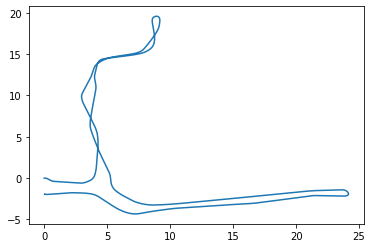

Map ID 23
Units are Meters. Robot is assumed to start facing right at coordinate (0,0)


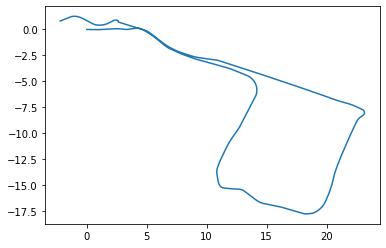

Map ID 21
Units are Meters. Robot is assumed to start facing right at coordinate (0,0)


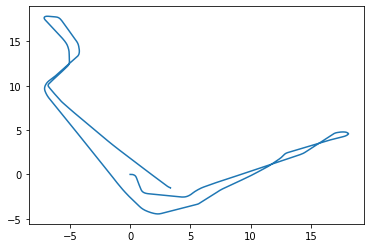

In [6]:
''' NOTE: Must NOT separate custom module imports from raw data import '''

# import custom modules + data

import dataloader

custom_modules = ["dataloader"]

# DELETE: assures up-to-date local modules are always used
for module_par in custom_modules:
    del sys.modules[module_par]

# RELOAD: assures up-to-date local modules are always used
import dataloader


# load all data from target folder
data_folder = "data"

# produces list with objects of class "map_object" in it
map_list_train = list(dataloader.load_folder(data_folder))

for map_number in range(len(map_list_train)):
    
    print("Map ID",map_list_train[map_number].id)
    print("Units are Meters. Robot is assumed to start facing right at coordinate (0,0)")
    
    plt.plot(map_list_train[map_number].cummulative_displacement[:,0],\
             map_list_train[map_number].cummulative_displacement[:,1])
    plt.show()

In [7]:
map_lidar_list = []
all_map_list = []
frame_counter = 0
for idx in range(len(map_list_train)):

    start = time.time()
    print("Execution Started")
    # lidar_data represents ALL observations for a map's lidar

    # numeric parameter of current map being analized. will be a function parameter at the end 
    # idx = 1

    # conversion factor (centimeters to meters)
    conv_factor = 10
    distance_factor = 2

    # numeric parameter of width of current map in centimeters. will be a function parameter at the end 
    map_cm = 100 * conv_factor
    map_cm = map_cm + 1

    if ((map_cm - 1)%2) > 0:
        print ("ISSUE WITH THE MAP DIMENSION!") 

    # center in x and y
    x_center = int((map_cm - 1)/2)
    y_center = x_center

    # map nummpy array (to be populated)
    map_array = np.zeros([map_cm,map_cm])

    # times, angles and ray return distances from a map id 'idx' 
    lidar_data = map_list_train[idx].lidar

    # Number of time observations for this map
    time_ob_cnt   = len(lidar_data)

    # time index where we start aligning lidar and encoder using a subsampled version of the encoder time array
    range_start = 3

    time_match_list = []

    ''' meas_per_tstep: get number of lidar measurements for every time step.
         lidar_angle_vec: get lidar angle vector array (same angles spanned for all measurements, hence 17 hardcoded)

    17 is safely HARDCODED here because, no matter how many time steps there are, there will be many more than 17 (picked that number just 'because') 
    all the measurements will have the same number of angular lidar measurements -1801 but didn't want to hardcode 1801, just in case.'''

    meas_per_tstep  ,   lidar_angle_vec =   lidar_data[17]['scan'].shape[0]  ,    lidar_data[17]['angle']

    # make list of transformations for local coordinate frame x and y distances
    ray_transform_vec =np.asarray([ [[np.cos(lidar_angle_vec[i]), -np.sin(lidar_angle_vec[i])],\
                                     [np.sin(lidar_angle_vec[i]),  np.cos(lidar_angle_vec[i])]]\
                                      for i in range(meas_per_tstep)]) 
    # transform list to array
    ray_transform_vec = np.squeeze(ray_transform_vec)

    #compute lidar off-center distance from wheelbase
    wheelbase_len   = 0.33020
    lidar_lever_len = 0.29833 - (wheelbase_len/2)

    # initialize old float (prior step) position for lidar basepoint
    x0_lidar_float_old = x_center + lidar_lever_len * conv_factor
    y0_lidar_float_old = y_center

    # initialize old int (prior step) position for lidar basepoint
    x1_lidar_int_old = 0
    y1_lidar_int_old = 0

    # fig_verification, ax_verification = plt.subplots(figsize=(10, 10))

    for time_step in tqdm(range(time_ob_cnt)):
    # for time_step in tqdm(range(1000)):

        time_array_encoder = map_list_train[idx].processed_encoder[:,0] 
        if time_step < range_start:
            time_closest_arg = (np.abs(time_array_encoder - map_list_train[idx].lidar[time_step]['t'])).argmin()

        else:
            time_closest_small = time_array_encoder[time_closest_arg:time_closest_arg+range_start]
            time_closest_arg = (np.abs(time_closest_small - map_list_train[idx].lidar[time_step]['t'])).argmin() +\
                                time_closest_arg

        # robot pose angle in RADIANS
        pose_angle = map_list_train[idx].cummulative_angle[time_closest_arg]

        # get x coordinate of robot, initially based on encoder
        x0_encoder_float = map_list_train[idx].cummulative_displacement[time_closest_arg,0]

        # transfer to centroid of lidar, account for lidar being off center with encoder
        x0_lidar_float = x0_encoder_float + lidar_lever_len*np.cos(pose_angle)

        # convert to small unit (i.e.: centimeters)    
        x0_lidar_float = x0_lidar_float * conv_factor

        # account for scaling center shift
        x0_lidar_float = x0_lidar_float + x_center

        # get y coordinate of robot, initially based on encoder
        y0_encoder_float = map_list_train[idx].cummulative_displacement[time_closest_arg,1]

        # transfer to centroid of lidar, account for lidar being off center with encoder
        y0_lidar_float= y0_encoder_float + lidar_lever_len*np.sin(pose_angle)

        # convert to small unit (i.e.: centimeters)
        y0_lidar_float= y0_lidar_float* conv_factor

        # account for center shift
        y0_lidar_float= y0_lidar_float+ y_center

        # measure distance travelled in time step
        distance_traveled = np.linalg.norm(np.array([[y0_lidar_float-y0_lidar_float_old],\
                                                     [x0_lidar_float-x0_lidar_float_old]]))

        # if distance travelled is less than 1/10th the number of measurements per meter, skip cell updates
        if distance_traveled < conv_factor/distance_factor:
            continue

        # if distance travelled is more than 1/10th the number of measurements per meter, update "old lidar locations"
        y0_lidar_float_old = y0_lidar_float
        x0_lidar_float_old = x0_lidar_float

        lidar_scan_vec  = lidar_data[time_step]['scan']

        # vector factors for translating local to global coordinate frame
        global_transform_vec = np.array([[np.cos(pose_angle)],[np.sin(pose_angle)]])

        '''At current time step, multiplies the hits (distances in meters) for every angle  
        by the corresponding local (2x2) transform for that angle'''    
        # returns scaled cosine and sine components of reading along the robot's local coordinate frame, 
        # arranged in 2x2 matrices within a list, ready to transfer to global frame 
        lidar_global_hit_locs = [lidar_scan_vec[i]*ray_transform_vec[i] for i in range(meas_per_tstep)]

        # converts this list reading to numpy array, in meters
        lidar_global_hit_locs = np.asarray(lidar_global_hit_locs)

        # adds ofset to x lidar distance reading (based on the lidar off-center mounting distance), in meters
        lidar_global_hit_locs = lidar_global_hit_locs + np.array([[lidar_lever_len,0],[0,lidar_lever_len]])

        # transform lidar to global frame for every reading, in meters
        lidar_global_hit_locs = [np.dot(lidar_global_hit_locs[i],global_transform_vec) for i in range(meas_per_tstep)]

        # converts to array and squeeze extra dimension
        lidar_global_hit_locs = (np.asarray(lidar_global_hit_locs))
        lidar_global_hit_locs = np.squeeze(lidar_global_hit_locs)

        for reading in range(len(lidar_global_hit_locs)):

            if lidar_data[time_step]['angle'][reading] < .5 and (reading<1080/2-360 or reading>1080/2+360) :
                continue
            # shift by encoder location AND convert to smaller unit
            x1_lidar_float = (np.squeeze(lidar_global_hit_locs[reading,0]) + x0_encoder_float) * conv_factor
            x1_lidar_float = x1_lidar_float + x_center

            y1_lidar_float = (np.squeeze(lidar_global_hit_locs[reading,1]) + y0_encoder_float) * conv_factor
            y1_lidar_float =  y1_lidar_float + y_center


            # convert all origin and end point to int variables
            x0_lidar_int = int(np.around(x0_lidar_float))
            y0_lidar_int = int(np.around(y0_lidar_float))
            x1_lidar_int = int(np.around(x1_lidar_float))
            y1_lidar_int = int(np.around(y1_lidar_float))



            '''QUESTIONABLE LOGIC HERE!!!! 
            
            ****NEVERMIND, THIS IS DONE WITHIN SAME TIME STEP --> Origin has NOT CHANGED'''
            # skip if the end points are exactly the same, even if origin has changed. QUESTIONABLE!!!
            if x1_lidar_int == x1_lidar_int_old and y1_lidar_int == y1_lidar_int_old:
                continue

            x1_lidar_int_old = x1_lidar_int
            y1_lidar_int_old = y1_lidar_int

            # generate list of impacted points
            points_impacted = list(bresenham(y0_lidar_int,x0_lidar_int, y1_lidar_int,x1_lidar_int ))

            if map_array[points_impacted[-1]]<100:
                map_array[points_impacted[-1]] += 10

            for i in points_impacted[0:-1]:
                if map_array[i] > -100: 
                    map_array[i] += -.5

            frame_counter +=1
            if frame_counter % 250 == 0 and idx == 0:
                map_lidar_list.append(np.copy(map_array))
    
    all_map_list.append(np.copy(map_array))
    print("Total Execution Time: {0}".format(time.time()-start) ) 

  0%|                                                 | 0/4962 [00:00<?, ?it/s]

Execution Started


  7%|██▌                                  | 264/3803 [00:00<00:02, 1650.55it/s]

Total Execution Time: 14.711004734039307
Execution Started


 12%|████▌                                | 589/4785 [00:00<00:00, 5273.03it/s]

Total Execution Time: 8.260903596878052
Execution Started


100%|█████████████████████████████████████| 4785/4785 [00:14<00:00, 333.46it/s]

Total Execution Time: 14.382408618927002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


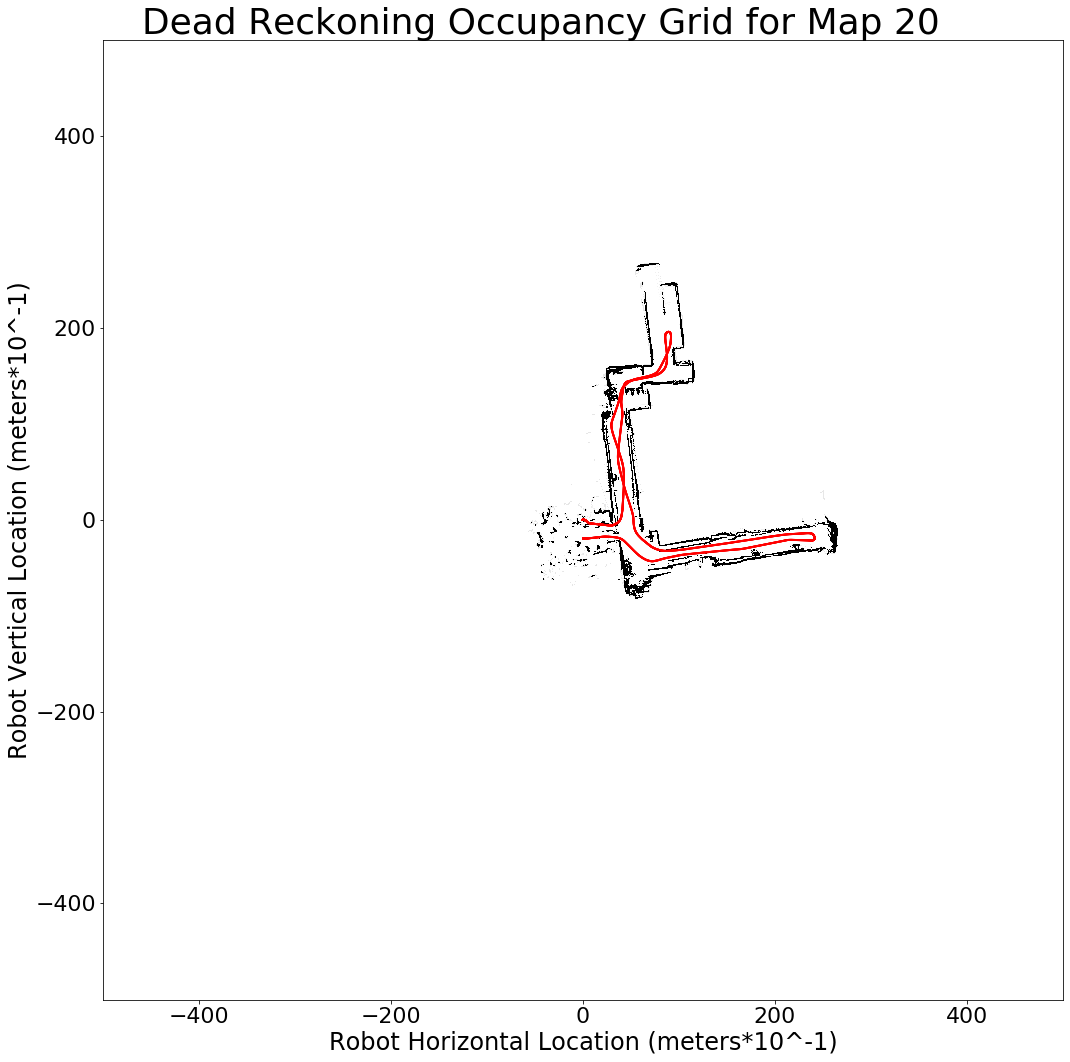

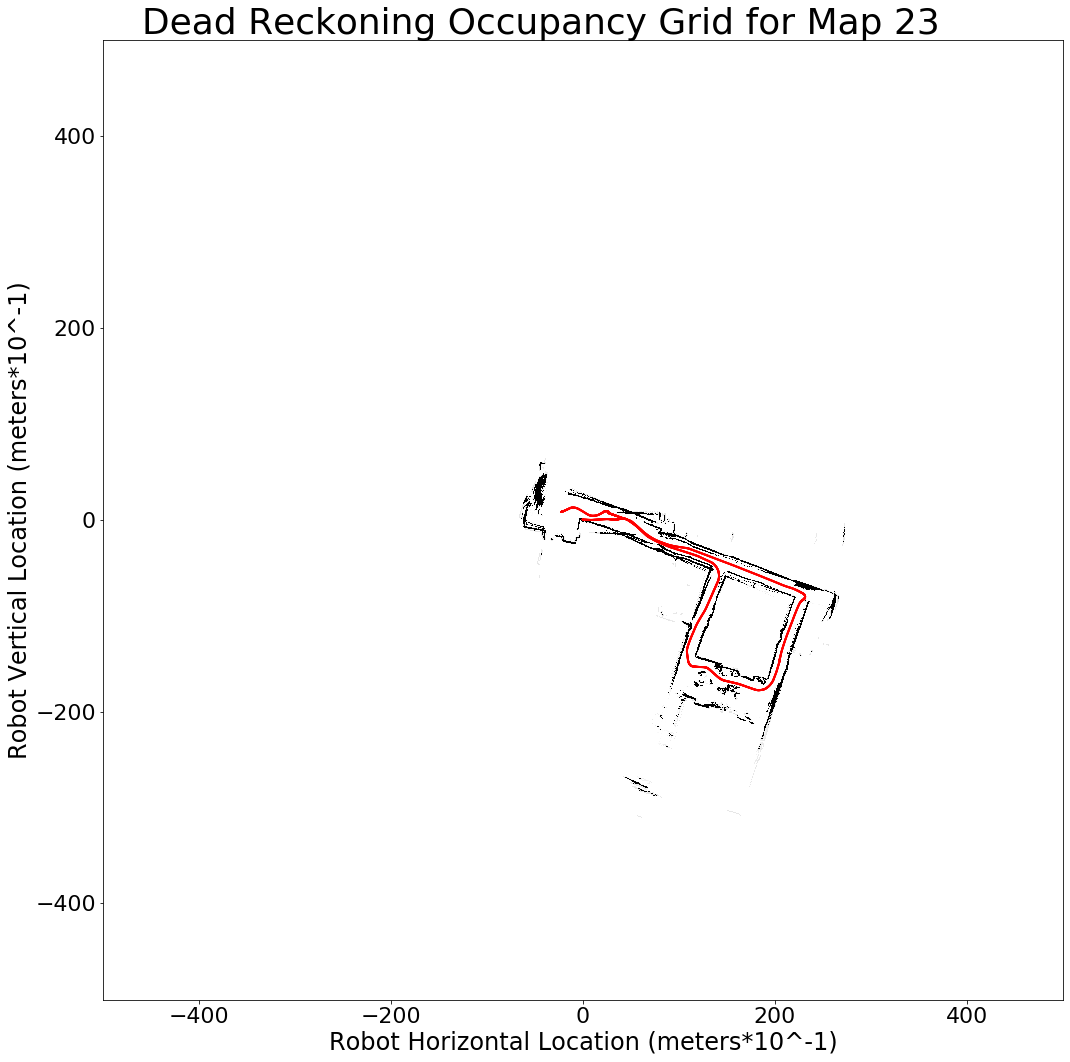

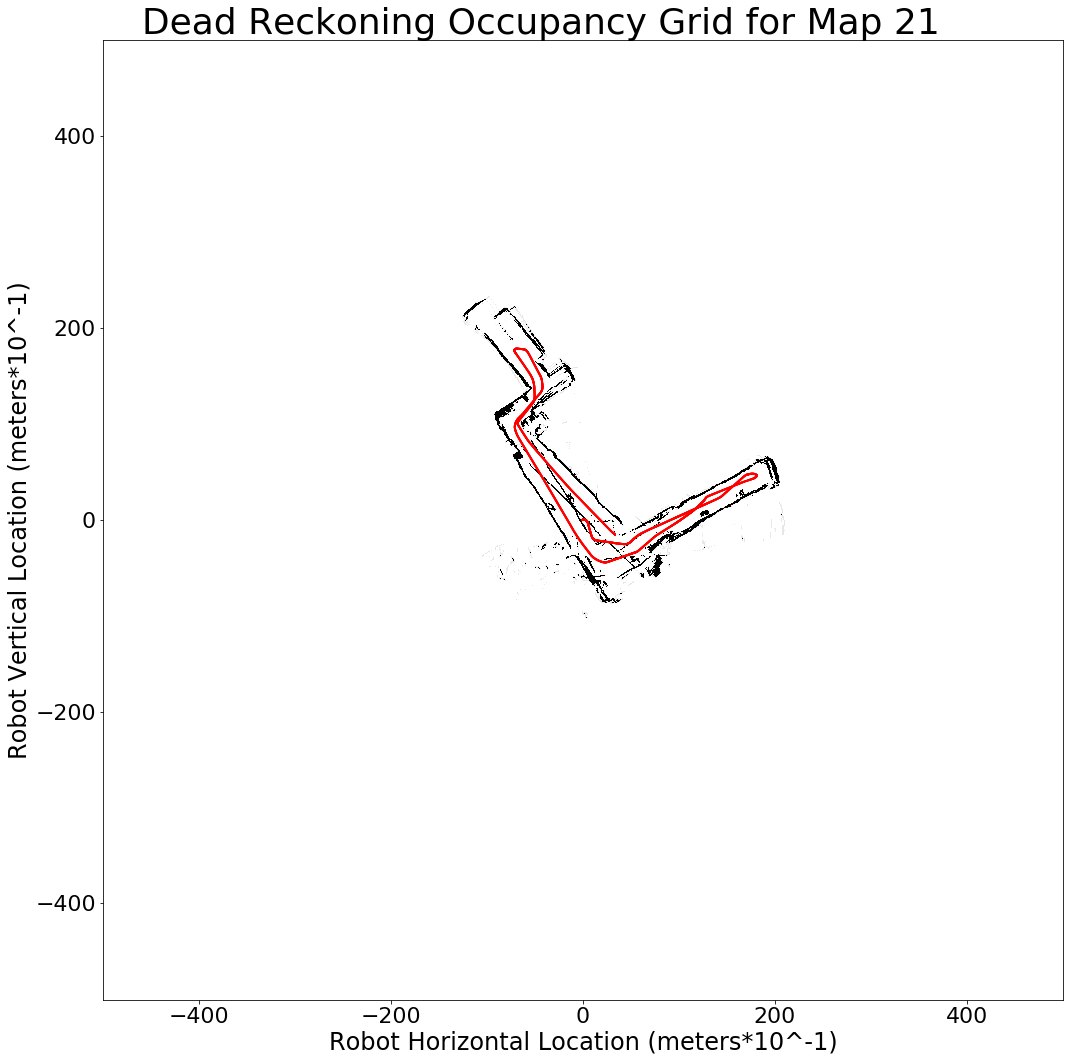

In [9]:
map_width = map_cm
for cnt,map_lidar in enumerate(all_map_list):
   
    fig, ax = plt.subplots(figsize=(15, 15))
    
    fig.suptitle('Dead Reckoning Occupancy Grid for Map {0}'.format(map_list_train[cnt].id), fontsize=36)
    ax.set_xlabel('Robot Horizontal Location (meters*10^-1)', fontsize=24)
    ax.set_ylabel('Robot Vertical Location (meters*10^-1)', fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=22)
    copy_map = np.copy(map_lidar)
    copy_map[copy_map<0] = 0
    copy_map[copy_map>10] = 100
    extent=(-map_width/2,map_width/2,-map_width/2,map_width/2)
    ax.imshow(copy_map, interpolation='nearest', origin = 'lower', extent = extent,cmap='binary' )
    ax.scatter(map_list_train[cnt].cummulative_displacement[:,0]*conv_factor,\
        map_list_train[cnt].cummulative_displacement[:,1]*conv_factor,\
        s=1, facecolors='none', edgecolors='r')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.show()
    fig.savefig("maps/odometry"+str(map_list_train[cnt].id)+".png")

In [ ]:
# !tar -czf workspace.tar.gz .